In [21]:
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import time
import seaborn as sns
import string
import pandas as pd
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


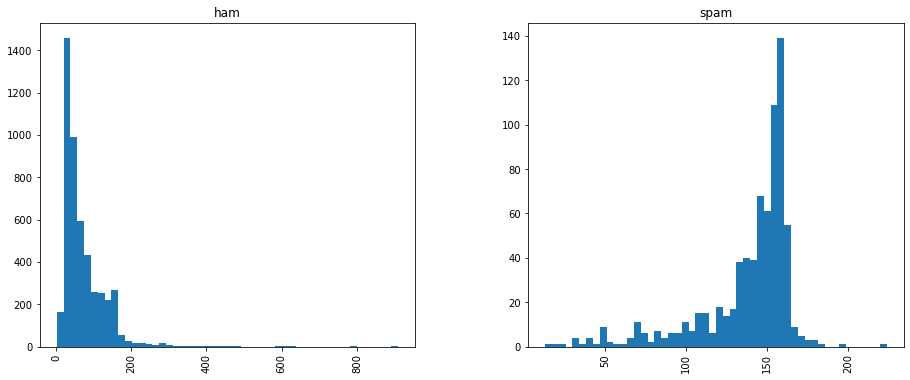

In [22]:
messages = pd.read_csv('D:\Универ\spam.csv', encoding='latin-1')
messages.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
messages = messages.rename(columns={'v1': 'class','v2': 'text'})
messages.groupby('class').describe()
messages['length'] = messages['text'].apply(len)
messages.hist(column='length',by='class',bins=50, figsize=(15,6))

def process_text(text):    
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)    
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return clean_words

In [23]:
from collections import Counter
Counter(messages['class'])

Counter({'ham': 4825, 'spam': 747})

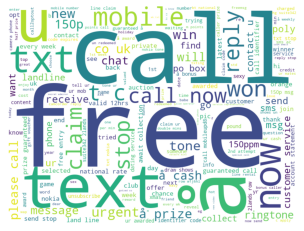

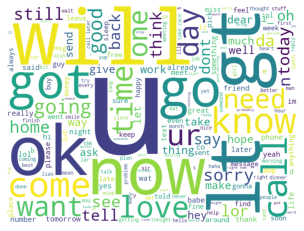

In [34]:
def visualize(label):
    text = ''
    for msg in messages[messages['class'] == label]['text']:
        msg = msg.lower()
        text += msg + ' '
    wordcloud = WordCloud(width=800, height=600, background_color="white").generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

visualize('spam')
visualize('ham')

In [25]:
messages['text'].apply(process_text).head()
msg_train, msg_test, class_train, class_test = train_test_split(messages['text'],messages['class'],test_size=0.2)

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       957
        spam       1.00      0.80      0.89       158

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy:  0.9721973094170404


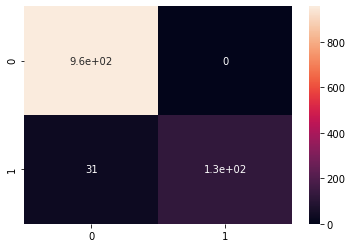

In [35]:
vectorizer = CountVectorizer(stop_words='english')
msg_train_transformed = vectorizer.fit_transform(msg_train)
msg_test_transformed = vectorizer.transform(msg_test)

rfc = RandomForestClassifier()
rfc.fit(msg_train_transformed, class_train)
predictions = rfc.predict(msg_test_transformed)

print(classification_report(class_test,predictions))
print('Accuracy: ', accuracy_score(class_test,predictions))
sns.heatmap(confusion_matrix(class_test,predictions),annot=True)
plt.show()

In [39]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 16})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=18)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=18)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.3, hspace=0.05)
    plt.show()

In [40]:
n_features = 500
n_components = 3
n_top_words = 5

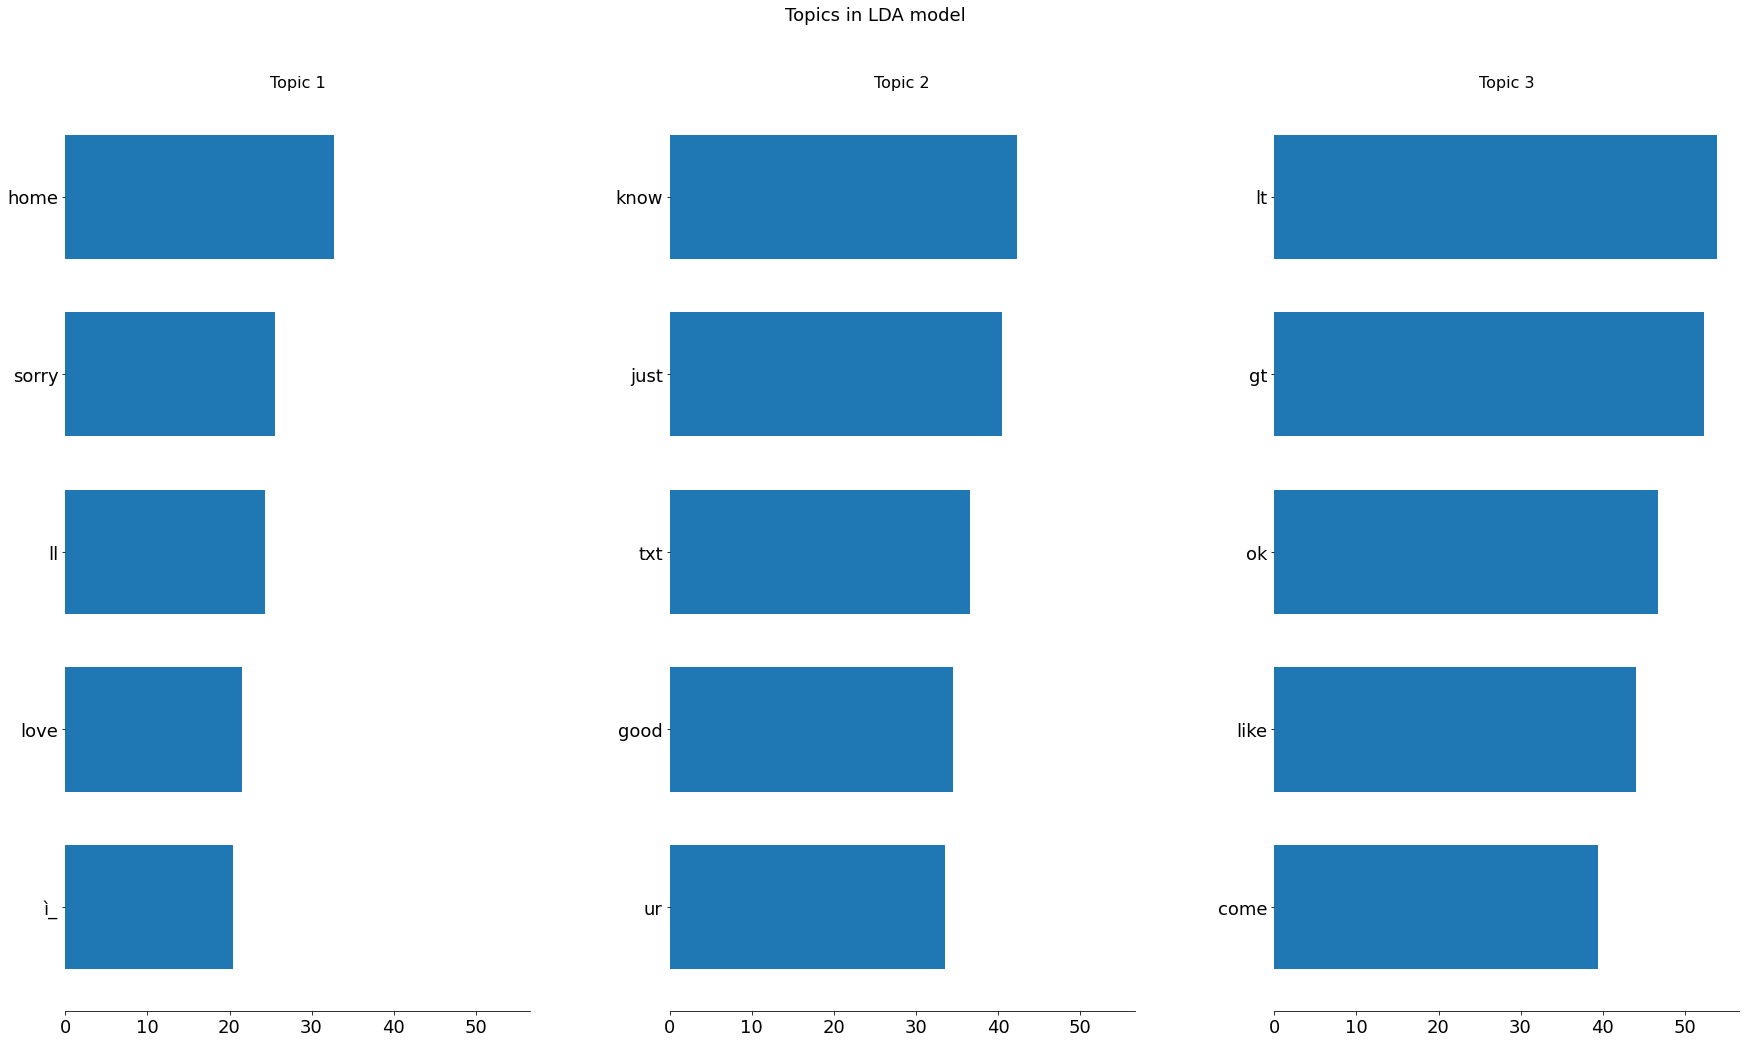

In [41]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50., random_state = 0)

lda.fit(msg_train_transformed)
lda.fit(msg_test_transformed)
feature_names = vectorizer.get_feature_names()
plot_top_words(lda, feature_names, n_top_words, 'Topics in LDA model')